In [110]:
import torch
import torchvision
import numpy as np
from torchvision import transforms

model = torchvision.models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT') 
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', weights='DeepLabV3_ResNet101_Weights.DEFAULT')
model.eval() #sets model in evaluation mode

filename = "testset/bird.jpg"

from PIL import Image
input_image = Image.open(filename)
#input_image = input_image.resize([512, 512]) # for large images
input_image = input_image.convert("RGB")


In [111]:
# The images have to be loaded in to a range of [0, 1] and then normalized using the following mean and std 
preprocess = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model(adds 1 more dimension to tensor)
#display(input_batch.shape) #[1, 3, 382, 272]

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)  # To get the maximum prediction of each class
display(output_predictions.shape)


torch.Size([382, 272])

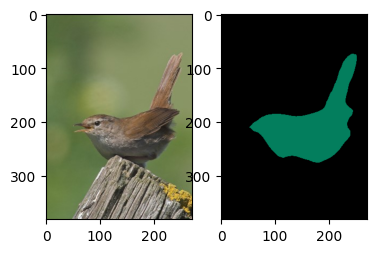

In [112]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.subplot(1, 3, 2)
plt.imshow(r)
plt.show()


In [113]:
'''
aspp_layer = model.classifier[4]
display(aspp_layer)
aspp_features = aspp_layer.weight.data.numpy()
display(aspp_features.shape)
'''
# retrieving aspp layer features 
aspp = torchvision.models.segmentation.deeplabv3.ASPP(in_channels=3, atrous_rates=[6, 12, 18])
aspp.eval()

aspp_features = aspp.forward(input_batch)
aspp_features = aspp_features.squeeze(0)
#display(aspp_features)
display(aspp_features.shape)

torch.Size([256, 382, 272])

In [114]:
import cv2
import numpy as np

def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()

    # Create Numpy arrays containing zeros.
    # Later to be used to fill them with respective red, green, and blue pixels.
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)

    for label_num in range(0, len(colors)):
        index = labels == label_num
        
        R, G, B = colors[label_num]

        red_map[index] = R
        green_map[index] = G
        blue_map[index] = B

    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map


def image_overlay(image, segmented_image):
    alpha = 1   # transparency for the original image
    beta = 0.8  # transparency for the segmentation map
    gamma = 0   # scalar added to each sum

    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    
    return image
     

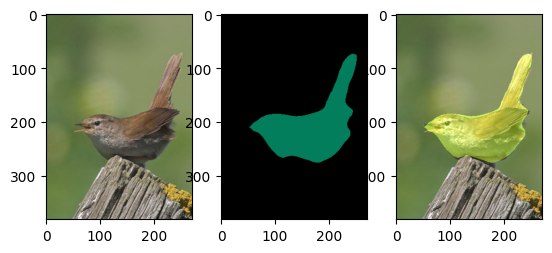

In [115]:
def perform_inference():
    # Get RGB segmentation map
    segmented_image = draw_segmentation_map(output)

    # Resize to original image size
    segmented_image = cv2.resize(segmented_image, input_image.size, cv2.INTER_LINEAR)
    overlayed_image = image_overlay(input_image, segmented_image)

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.subplot(1, 3, 2)
    plt.imshow(r)
    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    
    return

perform_inference()

In [121]:
# Applying PCA to ASPP features
from sklearn.decomposition import PCA

features = aspp_features.detach().numpy()
reshaped_aspp = features.reshape(256, features.shape[1]*features.shape[2])  # Reshape to [256, HEIGHT * WIDTH] (pca is applied to 2d data)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(reshaped_aspp.T).T # Transpose for the correct shape
pca_features = principalComponents.reshape(2, *features.shape[1:]) 

display(pca_features.shape)


array([[[-0.6513881 , -0.65026575, -0.6514098 , ..., -0.7058021 ,
         -0.7058021 , -0.70630866],
        [ 0.27286166,  0.27393135,  0.2752998 , ..., -0.39429352,
         -0.39448664, -0.39448664],
        [ 0.2811814 ,  0.28301463,  0.28358868, ..., -0.40532568,
         -0.4061109 , -0.4058075 ],
        ...,
        [ 0.01459353,  0.01318769,  0.01440833, ...,  0.93602425,
          0.21058477,  0.08487027],
        [ 0.02623812,  0.02729539,  0.02778348, ...,  0.15120997,
          0.04786418,  0.13382372],
        [ 0.02687569,  0.02700465,  0.02834076, ...,  0.07149165,
          0.21811578,  0.03837053]],

       [[ 1.7945228 ,  1.7928555 ,  1.796971  , ...,  1.8479398 ,
          1.8479398 ,  1.8477288 ],
        [-0.1724965 , -0.1706543 , -0.17023711, ..., -0.05395253,
         -0.05255534, -0.05255536],
        [-0.17025664, -0.16807422, -0.16666207, ..., -0.02555162,
         -0.02345979, -0.02468949],
        ...,
        [-0.29299745, -0.29325098, -0.29247934, ...,  

In [122]:
# Convert original image to LAB color space
from skimage import color 

lab_image = color.rgb2lab(input_image)
lab_image = np.transpose(lab_image, (2, 0, 1))
display(lab_image.shape)

pca_lab_sum = np.concatenate((lab_image, pca_features), axis=0)
display(pca_lab_sum.shape)

array([[[ 92.82234657,  92.82234657,  92.82234657, ...,  91.80695882,
          91.80695882,  91.80695882],
        [ 42.20455503,  42.20455503,  42.20455503, ...,  59.17899479,
          59.17899479,  59.17899479],
        [ 42.33228504,  42.33228504,  42.33228504, ...,  60.18361025,
          60.18361025,  60.18361025],
        ...,
        [ 50.58088448,  50.58088448,  50.58088448, ...,  32.51510303,
          57.69596707,  65.02372426],
        [ 50.18883101,  50.18883101,  50.18883101, ...,  62.68970808,
          67.12787278,  61.38850499],
        [ 50.18883101,  50.18883101,  50.18883101, ...,  64.03537492,
          53.11809016,  63.33303917]],

       [[-11.22236572, -11.22236572, -11.22236572, ...,  -5.61882556,
          -5.61882556,  -5.61882556],
        [-13.17365747, -13.17365747, -13.17365747, ...,  -6.36143205,
          -6.36143205,  -6.36143205],
        [-14.8736989 , -14.8736989 , -14.8736989 , ...,  -7.22130951,
          -7.22130951,  -7.22130951],
        ...,


(5, 382, 272)

array([[[ 9.28223466e+01,  9.28223466e+01,  9.28223466e+01, ...,
          9.18069588e+01,  9.18069588e+01,  9.18069588e+01],
        [ 4.22045550e+01,  4.22045550e+01,  4.22045550e+01, ...,
          5.91789948e+01,  5.91789948e+01,  5.91789948e+01],
        [ 4.23322850e+01,  4.23322850e+01,  4.23322850e+01, ...,
          6.01836103e+01,  6.01836103e+01,  6.01836103e+01],
        ...,
        [ 5.05808845e+01,  5.05808845e+01,  5.05808845e+01, ...,
          3.25151030e+01,  5.76959671e+01,  6.50237243e+01],
        [ 5.01888310e+01,  5.01888310e+01,  5.01888310e+01, ...,
          6.26897081e+01,  6.71278728e+01,  6.13885050e+01],
        [ 5.01888310e+01,  5.01888310e+01,  5.01888310e+01, ...,
          6.40353749e+01,  5.31180902e+01,  6.33330392e+01]],

       [[-1.12223657e+01, -1.12223657e+01, -1.12223657e+01, ...,
         -5.61882556e+00, -5.61882556e+00, -5.61882556e+00],
        [-1.31736575e+01, -1.31736575e+01, -1.31736575e+01, ...,
         -6.36143205e+00, -6.36143205e